In [11]:
import networkx as nx
import numpy as np
import pandas as pd
import random
import torch
import math
import bz2
import glob
import os
import _pickle as cPickle
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [8]:
main_graph = nx.erdos_renyi_graph(10, 0.15)
main_graph

In [5]:
random.sample(list(main_graph.nodes()), 8)

[3, 7, 0, 9, 2, 6, 4, 1]

In [6]:
iso = nx.isolates(main_graph)
main_graph.remove_nodes_from(iso)

RuntimeError: dictionary changed size during iteration

In [18]:
main_graph.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8))

In [13]:
def complete_disconnected_graph(g):
    
    g_comp = list(nx.connected_components(g))
    
    while len(g_comp) > 1:
        g.add_edge(random.sample(g_comp[0], 1)[0], random.sample(g_comp[1], 1)[0])
        g_comp = list(nx.connected_components(g))
    
        
    
def generate_synthetic_graphs(n_graphs=2,
                              n_nodes=100,
                              main_graph="ER",
                              edge_removal_prob=0.1,
                              node_removal_prob=0.1):

    graphs = []

    if main_graph == "karate":
        g0 = nx.karate_club_graph()
    elif main_graph == "ER":
        g0 = nx.erdos_renyi_graph(n=n_nodes, p=0.15)
    elif main_graph == "PA":
        g0 = nx.barabasi_albert_graph(n=n_nodes, m=n_nodes//20)
    else:
        raise NotImplementedError

    # Complete graph (in case of isolates or disconnected components):
    complete_disconnected_graph(g0)
    
    graphs.append(g0)

    for i in range(n_graphs - 1):
        edge_prob = np.random.binomial(1, edge_removal_prob, size=g0.number_of_edges()).astype(bool)
        sampled_edges = np.array(list(g0.edges()))[~edge_prob]
        
        ng = nx.Graph()
        ng.add_edges_from(sampled_edges)
        
        node_prob = np.random.binomial(1, node_removal_prob, size=ng.number_of_nodes()).astype(bool)
        sampled_nodes = np.array(list(ng.nodes()))[node_prob]
        
        ng.remove_nodes_from(sampled_nodes)
        
        # Complete graph (in case of isolates or disconnected components):
        complete_disconnected_graph(ng)
        
        graphs.append(ng)
    
    return graphs

graphs = generate_synthetic_graphs(n_graphs=5, n_nodes=15, main_graph="karate")

Graph 0:
# of the nodes: 34


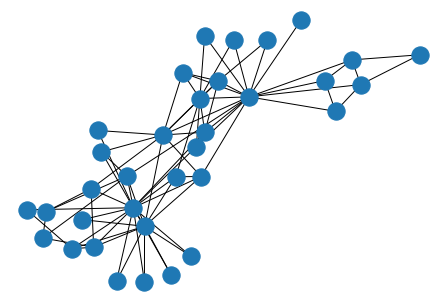

Graph 1:
# of the nodes: 32


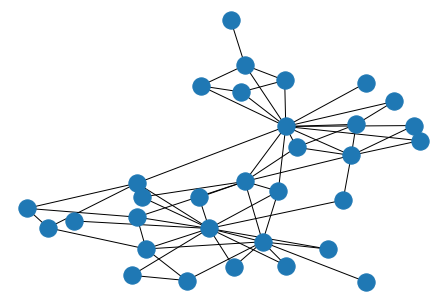

Graph 2:
# of the nodes: 31


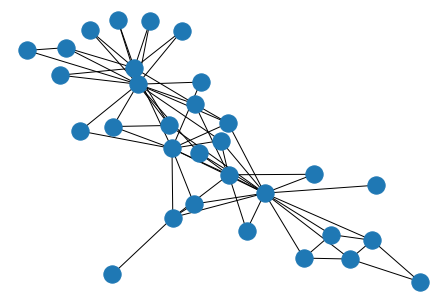

Graph 3:
# of the nodes: 31


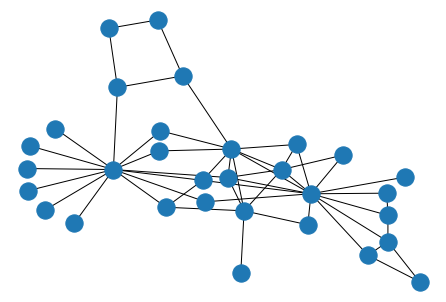

Graph 4:
# of the nodes: 31


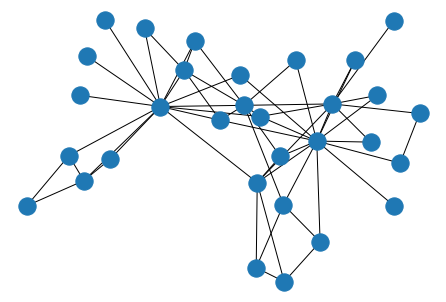

In [14]:
for i, g in enumerate(graphs):
    print("Graph %d:" % i)
    print("# of the nodes: %d" % g.number_of_nodes())
    nx.draw(g)
    plt.show()

In [41]:
import torch_geometric as tg


def get_closest_anchors(g, anchors, k=3):
    closest_anchors = {}

    for i, n in enumerate(g.nodes()):
        anchor_dist = []
        for an in anchors:
            anchor_dist.append((an, nx.shortest_path_length(g, source=n, target=an)))

        closest_anchors[n] = sorted(anchor_dist, key=lambda x: x[1])[:k]

    return closest_anchors


def get_pairwise_anchors(g1, g2):
    return set(g1.nodes()).intersection(set(g2.nodes()))


def from_nx_to_tg_graphs(graphs):

    tg_graphs = []

    for i, g1 in enumerate(graphs):

        tg_g1 = tg.utils.from_networkx(g1)
        tg_g1['gidx'] = i
        tg_g1['anchor_nodes'] = {}

        for j, g2 in enumerate(graphs):
            if i != j:
                tg_g1['anchor_nodes'][j] = get_closest_anchors(g1, get_pairwise_anchors(g1, g2))

        tg_graphs.append(tg_g1)

    return tg_graphs

In [42]:
tg_graphs = from_nx_to_tg_graphs(graphs)

In [44]:
tg_graphs[2].edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
          1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
          3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,
          8,  8,  9,  9,  9, 10, 11, 11, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15,
         15, 15, 15, 16, 16, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 20, 21, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29,
         29, 29, 30, 30],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0,  2,  3,
         11, 12, 13, 14, 16,  0,  1,  3,  7,  8, 17, 11, 18, 19, 20,  0,  1,  2,
          7, 21,  0,  6,  9,  0,  6,  9, 22,  0,  4,  5, 22,  0,  2,  3,  0,  2,
         16, 23,  0,  4,  5,  0,  0,  1,  2, 23,  0,  1,  0,  1, 23,  0,  1,  0,
         19, 20, 23,  1,  8, 20, 23,  2, 23,  2, 23,  2, 15, 23,  2, 15, 16, 24,
  

In [28]:
tbl1 = pd.DataFrame({"A": [1, 2, 3, 4], "B": [5.2, 3.4, 1.5, 0.3]})
tbl2 = pd.DataFrame({"A": [3, 4], "C": [0.001, 0.34]})
pd.merge(tbl1, tbl2, how='outer')

A    B      C
0  1  5.2    NaN
1  2  3.4    NaN
2  3  1.5  0.001
3  4  0.3  0.340

In [35]:
list(nx.all_shortest_paths(graphs[0], source=0, target=30))

[[0, 1, 30], [0, 8, 30]]

In [37]:
def get_closest_anchors(g, anchors, k=3):
    
    closest_anchors = {}
    
    for i, n in enumerate(g.nodes()):
        anchor_dist = []
        for an in anchors:
            anchor_dist.append((an, nx.shortest_path_length(g, source=n, target=an)))
        
        closest_anchors[i] = sorted(anchor_dist, key=lambda x: x[1])[:k]
        
    return closest_anchors

length = dict(nx.all_pairs_shortest_path_length(graphs[0]))
length

{0: {0: 0,
  1: 1,
  2: 1,
  3: 1,
  4: 1,
  5: 1,
  6: 1,
  7: 1,
  8: 1,
  10: 1,
  11: 1,
  12: 1,
  13: 1,
  17: 1,
  19: 1,
  21: 1,
  31: 1,
  30: 2,
  9: 2,
  27: 2,
  28: 2,
  32: 2,
  16: 2,
  33: 2,
  24: 2,
  25: 2,
  23: 3,
  14: 3,
  15: 3,
  18: 3,
  20: 3,
  22: 3,
  29: 3,
  26: 3},
 1: {1: 0,
  0: 1,
  2: 1,
  3: 1,
  7: 1,
  13: 1,
  17: 1,
  19: 1,
  21: 1,
  30: 1,
  4: 2,
  5: 2,
  6: 2,
  8: 2,
  10: 2,
  11: 2,
  12: 2,
  31: 2,
  9: 2,
  27: 2,
  28: 2,
  32: 2,
  33: 2,
  16: 3,
  24: 3,
  25: 3,
  23: 3,
  14: 3,
  15: 3,
  18: 3,
  20: 3,
  22: 3,
  29: 3,
  26: 3},
 2: {2: 0,
  0: 1,
  1: 1,
  3: 1,
  7: 1,
  8: 1,
  9: 1,
  13: 1,
  27: 1,
  28: 1,
  32: 1,
  4: 2,
  5: 2,
  6: 2,
  10: 2,
  11: 2,
  12: 2,
  17: 2,
  19: 2,
  21: 2,
  31: 2,
  30: 2,
  33: 2,
  23: 2,
  24: 2,
  14: 2,
  15: 2,
  18: 2,
  20: 2,
  22: 2,
  29: 2,
  16: 3,
  25: 3,
  26: 3},
 3: {3: 0,
  0: 1,
  1: 1,
  2: 1,
  7: 1,
  12: 1,
  13: 1,
  4: 2,
  5: 2,
  6: 2,
  8: 2,
  10: 2

In [66]:
graphs[0].add_node('ktest')
list(graphs[0].nodes()).index('ktest')

34

In [63]:
set(graphs[1].nodes()) - set(graphs[0].nodes())

set()

In [67]:
li = [('k', 1), ('f', 2), ('s', 3)]
np.random.shuffle(li)
li

[('k', 1), ('s', 3), ('f', 2)]

In [72]:
g1 = graphs[0]
positive_anchors = [5, 3, 1]
list(np.where(np.isin(positive_anchors, list(g1.nodes()))))

[array([0, 1, 2])]

In [107]:
graphs[0].remove_node('ktest')

In [76]:
min(1, 0, 3, -2)

-2

In [212]:
import networkx as nx
import numpy as np
import torch
import torch_geometric as tg
import math
import random


def get_closest_anchors(g, anchors, k, normalize_dist=True, shuffle=True):

    ei_nodes = [] # edge index nodes
    ei_anchors = [] # edge index anchors
    sp_dist = [] # short path distance


    for i, n in enumerate(g.nodes()):

        anchor_dist = []

        for an in anchors:
            anchor_dist.append((list(g.nodes()).index(an),
                                nx.shortest_path_length(g, source=n, target=an)))

        if shuffle:
            # Shuffle randomly to account for collisions
            np.random.shuffle(anchor_dist)

        if k is not None:
            anchor_dist = sorted(anchor_dist, key=lambda x: x[1])[:k]

        anchor_idx, dist = [list(t) for t in zip(*anchor_dist)]

        dist = list(1./(np.array(dist) + 1))

        if normalize_dist:
            dist = list(np.array(dist) / sum(dist))

        ei_nodes += [i]*len(anchor_idx)
        ei_anchors += anchor_idx
        sp_dist += dist

    return {
        'closest_anchors': torch.stack([torch.Tensor(ei_nodes),
                                        torch.Tensor(ei_anchors)], dim=0).to(torch.long),
        'sp_dist': torch.Tensor(sp_dist).reshape(-1, 1)
    }


def sample_negative_anchors(neg_anchor_edge_index, num_negative):

    perm = random.sample(range(neg_anchor_edge_index.size(1)),
                         min(num_negative, neg_anchor_edge_index.size(1)))
    perm = torch.tensor(perm)
    perm = perm.to(torch.long)

    return neg_anchor_edge_index[:, perm]


def obtain_negative_anchors(g1, g2):
    """
    Sample negative anchors randomly.

    :param g1:
    :param g2:
    :param num_negative:
    :return:
    """

    positive_anchors = list(set(g1.nodes()).intersection(set(g2.nodes())))

    row = [i for i, n in enumerate(g1.nodes()) if n in positive_anchors]
    col = [i for i, n in enumerate(g2.nodes()) if n in positive_anchors]

    neg_adj_mask = torch.ones(g1.number_of_nodes(), g2.number_of_nodes(), dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
    neg_adj_mask[row, col] = 0

    neg_row, neg_col = neg_adj_mask.nonzero().t()

    return torch.stack([neg_col, neg_row], dim=0).to(torch.long)


def get_positive_anchors(g1, g2, test_ratio, shuffle=True):
    """

    :param g1: networkx graph 1
    :param g2: networkx graph 2
    :param test_ratio: test split ratio
    :param shuffle: flag to shuffle the anchor nodes

    """

    positive_anchors = list(set(g1.nodes()).intersection(set(g2.nodes())))

    if shuffle:
        np.random.shuffle(positive_anchors)

    g1_ei = [i for i, n in enumerate(g1.nodes()) if n in positive_anchors]
    g2_ei = [i for i, n in enumerate(g2.nodes()) if n in positive_anchors]

    anchor_ei = torch.stack([torch.Tensor(g1_ei), torch.Tensor(g2_ei)], dim=0).to(torch.long)

    if test_ratio is None or test_ratio == 0.0:

        return {
            'positive_anchors': positive_anchors,
            'train_positive_anchors': positive_anchors,
            'test_positive_anchors': positive_anchors,
            'anchor_edge_index': anchor_ei,
            'train_anchor_edge_index': anchor_ei,
            'test_anchor_edge_index': anchor_ei
        }

    else:

        n_t = int(math.floor(test_ratio*len(positive_anchors)))

        train_positive_anchors, test_positive_anchors = positive_anchors[n_t:], positive_anchors[:n_t]

        train_ei, test_ei = anchor_ei[:, n_t:], anchor_ei[:, :n_t]

        return {
            'positive_anchors': positive_anchors,
            'train_positive_anchors': train_positive_anchors,
            'test_positive_anchors': test_positive_anchors,
            'anchor_edge_index': anchor_ei,
            'train_anchor_edge_index': train_ei,
            'test_anchor_edge_index': test_ei
        }


def from_nx_to_tg_graphs(graphs, attributes=None, k_nearest=3, test_ratio=0.8, normalize_dist=True):

    tg_graphs = []

    for i, g1 in enumerate(graphs):

        tg_g1 = tg.utils.from_networkx(g1)
        tg_g1['gidx'] = 'g' + str(i)
        tg_g1['anchor_data'] = {}

        # If the graph is not attributed, add the node degrees as attributes:
        if attributes is None:
            tg_g1.x = torch.Tensor(list(dict(g1.degree()).values())).reshape(-1, 1)

        for j, g2 in enumerate(graphs):
            if j == i:
                continue
            if j < i:

                tg_g1['anchor_data']['g' + str(j)] = {}

                for k, v in tg_graphs[j]['anchor_data']['g' + str(i)].items():
                    if 'positive_anchors' in k:
                        tg_g1['anchor_data']['g' + str(j)][k] = v
                    elif 'anchor_edge_index' in k:
                        tg_g1['anchor_data']['g' + str(j)][k] = v[[-1, 0], :]


            if j > i:

                tg_g1['anchor_data']['g' + str(j)] = get_positive_anchors(g1, g2, test_ratio)

            tg_g1['anchor_data']['g' + str(j)].update(get_closest_anchors(g1,
                                                                          tg_g1['anchor_data']['g' + str(j)]['positive_anchors'],
                                                                          k_nearest,
                                                                          normalize_dist))

            tg_g1['anchor_data']['g' + str(j)]['negative_anchor_edge_index'] = obtain_negative_anchors(g1, g2)
            tg_g1['anchor_data']['g' + str(j)]['test_negative_anchor_edge_index'] = sample_negative_anchors(tg_g1['anchor_data']['g' + str(j)]['negative_anchor_edge_index'],
                                                                                                            tg_g1['anchor_data']['g' + str(j)]['test_anchor_edge_index'].size(1))



        tg_graphs.append(tg_g1)

    return tg_graphs



In [213]:
tg_graphs = from_nx_to_tg_graphs(graphs)

In [214]:
tg_graphs[1].anchor_data['g2']

{'positive_anchors': [12,
  11,
  7,
  20,
  28,
  19,
  3,
  33,
  31,
  15,
  21,
  27,
  2,
  32,
  8,
  14,
  22,
  1,
  18,
  5,
  9,
  17,
  0,
  29,
  10,
  26,
  4,
  16,
  6],
 'train_positive_anchors': [29, 10, 26, 4, 16, 6],
 'test_positive_anchors': [12,
  11,
  7,
  20,
  28,
  19,
  3,
  33,
  31,
  15,
  21,
  27,
  2,
  32,
  8,
  14,
  22,
  1,
  18,
  5,
  9,
  17,
  0],
 'anchor_edge_index': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 17, 18, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]),
 'train_anchor_edge_index': tensor([[23, 24, 25, 26, 29, 31],
         [25, 26, 27, 28, 29, 30]]),
 'test_anchor_edge_index': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22],
         [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 17,

In [128]:
import os.path as osp
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import train_test_split_edges

dataset = 'Cora'
path = osp.join('..', 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]

# Train/validation/test
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)

In [129]:
data

Data(test_neg_edge_index=[2, 527], test_pos_edge_index=[2, 527], train_neg_adj_mask=[2708, 2708], train_pos_edge_index=[2, 8976], val_neg_edge_index=[2, 263], val_pos_edge_index=[2, 263], x=[2708, 1433])

In [130]:
x, pos_edge_index = data.x, data.train_pos_edge_index
x, pos_edge_index

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]))

In [133]:
x.shape

torch.Size([2708, 1433])

In [135]:
total_edge_index = torch.cat([pos_edge_index, pos_edge_index], dim=-1)
total_edge_index.shape

torch.Size([2, 17952])

In [136]:
pos_edge_index.shape

torch.Size([2, 8976])

In [137]:
8976*2

17952

In [139]:
x_j = torch.index_select(x, 0, total_edge_index[0])
x_i = torch.index_select(x, 0, total_edge_index[1])
res = torch.einsum("ef,ef->e", x_i, x_j)
res, res.shape

(tensor([0.0117, 0.0148, 0.0058,  ..., 0.0070, 0.0081, 0.0110]),
 torch.Size([17952]))

In [140]:
x_i.shape

torch.Size([17952, 1433])

In [141]:
x_j.shape

torch.Size([17952, 1433])

In [142]:
t1 = torch.Tensor([
    [1, 2, 3],
    [4, 5, 6]
])

t2 = torch.Tensor([
    [7, 8, 9],
    [13, 14, 15]
])

torch.cat([t1, t2], dim=-1)

tensor([[ 1.,  2.,  3.,  7.,  8.,  9.],
        [ 4.,  5.,  6., 13., 14., 15.]])

In [146]:
tg.utils.degree(tg_graphs[0].edge_index, tg_graphs)

RuntimeError: invalid argument 3: Index tensor must have same dimensions as output tensor at /Users/distiller/project/conda/conda-bld/pytorch_1579022061893/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:700

In [148]:
tg_graphs[0].edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [163]:
torch.Tensor(list(dict(graphs[0].degree()).values())).reshape(-1, 1)

tensor([[16.],
        [ 9.],
        [10.],
        [ 6.],
        [ 3.],
        [ 4.],
        [ 4.],
        [ 4.],
        [ 5.],
        [ 2.],
        [ 3.],
        [ 1.],
        [ 2.],
        [ 5.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 3.],
        [ 2.],
        [ 2.],
        [ 2.],
        [ 5.],
        [ 3.],
        [ 3.],
        [ 2.],
        [ 4.],
        [ 3.],
        [ 4.],
        [ 4.],
        [ 6.],
        [12.],
        [17.]])

In [182]:
def anchor_node_embeddings(x, anchors_edge_index, sp_dist):

    x_nodes = torch.index_select(x, 0, anchors_edge_index[0])
    x_anchors = torch.index_select(x, 0, anchors_edge_index[1])

    anc_x = torch.cat([x_nodes, x_anchors], dim=-1) * sp_dist.reshape(-1, 1)

    labels = anchors_edge_index[0].view(anchors_edge_index[0].size(0), 1).expand(-1, anc_x.size(1))

    unique_labels = labels.unique(dim=0)

    res = torch.zeros_like(unique_labels, dtype=torch.float).scatter_add_(0, labels, anc_x)

    return res

tg1, tg2 = tg_graphs[:2]
x1 = anchor_node_embeddings(tg1.x, tg1.anchor_nodes[tg2.gidx]['closest_anchors'],
                            tg1.anchor_nodes[tg2.gidx]['sp_dist'])

x2 = anchor_node_embeddings(tg2.x, tg2.anchor_nodes[tg1.gidx]['closest_anchors'],
                            tg2.anchor_nodes[tg1.gidx]['sp_dist'])

x1, x2

(tensor([[16.0000, 10.0000],
         [ 9.0000,  9.2500],
         [10.0000,  9.2500],
         [ 6.0000,  9.2500],
         [ 3.0000,  6.2500],
         [ 4.0000,  6.5000],
         [ 4.0000,  6.7500],
         [ 4.0000,  8.2500],
         [ 5.0000,  9.0000],
         [ 2.0000,  7.7500],
         [ 3.0000,  6.5000],
         [ 1.0000,  5.4545],
         [ 2.0000,  6.5000],
         [ 5.0000, 14.0000],
         [ 2.0000,  8.2500],
         [ 2.0000,  8.2500],
         [ 2.0000,  3.0000],
         [ 2.0000,  7.2500],
         [ 2.0000,  8.2500],
         [ 3.0000,  9.7500],
         [ 2.0000,  8.2500],
         [ 2.0000,  7.2500],
         [ 2.0000,  8.2500],
         [ 5.0000,  7.5000],
         [ 3.0000,  3.7500],
         [ 3.0000,  3.7500],
         [ 2.0000,  6.2500],
         [ 4.0000,  7.0000],
         [ 3.0000,  8.2500],
         [ 4.0000,  7.5000],
         [ 4.0000, 11.3333],
         [ 6.0000,  4.5000],
         [12.0000, 10.7500],
         [17.0000, 10.5000]]),
 tensor([[16

In [185]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos(x1, x2)

RuntimeError: The size of tensor a (34) must match the size of tensor b (32) at non-singleton dimension 0

In [189]:
import torch.nn.functional as F
F.cosine_similarity(x1, x2, 2)

RuntimeError: The size of tensor a (34) must match the size of tensor b (32) at non-singleton dimension 0

In [191]:
g1, g2 = graphs[:2]
positive_anchors = list(set(g1.nodes()).intersection(set(g2.nodes())))

row = [i for i, n in enumerate(g1.nodes()) if n in positive_anchors]
col = [i for i, n in enumerate(g2.nodes()) if n in positive_anchors]

neg_adj_mask = torch.ones(g1.number_of_nodes(), g2.number_of_nodes(), dtype=torch.uint8)
print(neg_adj_mask, neg_adj_mask.shape)
print("----")
neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
print(neg_adj_mask, neg_adj_mask.shape)
print("----")
neg_adj_mask[row, col] = 0
print(neg_adj_mask, neg_adj_mask.shape)
print("----")

print(neg_adj_mask.nonzero().t(), neg_adj_mask.nonzero().t().shape)
neg_row, neg_col = neg_adj_mask.nonzero().t()

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8) torch.Size([34, 32])
----
tensor([[False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]]) torch.Size([34, 32])
----
tensor([[False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, Fal

In [201]:
mdict = {1: 2}
mdict.update({'s': 't'})
mdict

{1: 2, 's': 't'}

In [224]:
def greedy_matching(total_edge_index, sim_scores):
    
    pred_pairs = []
    
    while total_edge_index.shape[1] > 0:
        
        pair_idx = np.argmax(sim_scores)
        
        a, b = total_edge_index[:, pair_idx].flatten()
        pred_pairs.append((a, b))
        
        step_filt = (total_edge_index[0, :] != a) & (total_edge_index[1, :] != b)
        
        total_edge_index = total_edge_index[:, step_filt]
        sim_scores = sim_scores[step_filt]
    
    return pred_pairs
        
        

total_edge_index = np.array([
    [1, 1, 1, 2, 2, 2, 3, 3, 3],
    [4, 6, 5, 5, 6, 4, 6, 4, 5]
])

sim_score = np.array([0.6, 0.5, 0.2, 0.75, 0.2, 0.1, 0.83, 0.94, 0.2])

greedy_matching(total_edge_index, sim_score)

[(3, 4), (2, 5), (1, 6)]

In [244]:
def soft_ordering(total_edge_index, sim_scores):

    df = pd.DataFrame(np.concatenate((total_edge_index, sim_scores.reshape(1, -1))).T,
                      columns=['source', 'target', 'score'])
    
    df['source'] = df['source'].astype(np.int)
    df['target'] = df['target'].astype(np.int)
    
    df = df.sort_values(by=['source', 'score'], ascending=False)

    target_order = {}

    for s in df['source'].unique():
        sorted_targets = df.loc[df['source'] == s, 'target']
        target_order[s] = list(sorted_targets)

    return target_order

soft_ordering(total_edge_index, sim_score)

{3: [4, 6, 5], 2: [5, 6, 4], 1: [4, 6, 5]}

In [220]:
(ei[0, :] == 1) | (ei[1, :] == 4)

array([ True,  True,  True, False, False,  True, False,  True, False])

In [232]:
list(map(tuple, tg_graphs[0].edge_index.numpy().T))

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 17),
 (0, 19),
 (0, 21),
 (0, 31),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 7),
 (1, 13),
 (1, 17),
 (1, 19),
 (1, 21),
 (1, 30),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 13),
 (2, 27),
 (2, 28),
 (2, 32),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 7),
 (3, 12),
 (3, 13),
 (4, 0),
 (4, 6),
 (4, 10),
 (5, 0),
 (5, 6),
 (5, 10),
 (5, 16),
 (6, 0),
 (6, 4),
 (6, 5),
 (6, 16),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (8, 0),
 (8, 2),
 (8, 30),
 (8, 32),
 (8, 33),
 (9, 2),
 (9, 33),
 (10, 0),
 (10, 4),
 (10, 5),
 (11, 0),
 (12, 0),
 (12, 3),
 (13, 0),
 (13, 1),
 (13, 2),
 (13, 3),
 (13, 33),
 (14, 32),
 (14, 33),
 (15, 32),
 (15, 33),
 (16, 5),
 (16, 6),
 (17, 0),
 (17, 1),
 (18, 32),
 (18, 33),
 (19, 0),
 (19, 1),
 (19, 33),
 (20, 32),
 (20, 33),
 (21, 0),
 (21, 1),
 (22, 32),
 (22, 33),
 (23, 25),
 (23, 27),
 (23, 29),
 (23, 32),
 (23, 33),
 (24, 25),
 (24, 27),
 (24, 31),
 (25, 

In [248]:
graphs[0].graph['name']

"Zachary's Karate Club"

In [251]:
df = pd.DataFrame({'k': [1, 2], 'm': [4, 5]})
df.mean().to_csv("test.csv")

In [252]:
sum([1., 2., np.inf])

inf

In [254]:
nx.single_source_shortest_path_length(graphs[0], 1, cutoff=3)

{1: 0,
 0: 1,
 2: 1,
 3: 1,
 7: 1,
 13: 1,
 17: 1,
 19: 1,
 21: 1,
 30: 1,
 4: 2,
 5: 2,
 6: 2,
 8: 2,
 10: 2,
 11: 2,
 12: 2,
 31: 2,
 9: 2,
 27: 2,
 28: 2,
 32: 2,
 33: 2,
 16: 3,
 24: 3,
 25: 3,
 23: 3,
 14: 3,
 15: 3,
 18: 3,
 20: 3,
 22: 3,
 29: 3,
 26: 3}

In [257]:
graphs[0].graph['k'] = np.random.normal(size=200)
graphs[0].graph

{'name': "Zachary's Karate Club",
 'k': array([-2.93973705,  0.14867351,  3.03836008,  0.15433315, -1.18748569,
         0.74074268, -0.11630075, -0.30504314,  0.34821033, -0.0663727 ,
        -0.81339749,  1.54005543, -0.71457989, -0.35724353,  0.89657673,
         0.24298787,  0.21802075,  0.83512834, -0.54695491,  0.26264084,
         0.66087211,  1.50378498, -0.84695209, -0.91553656, -0.12393541,
        -0.03231094,  1.12770179,  1.08168829, -0.61780342, -0.38912828,
        -0.83519836, -1.20632212,  0.395407  ,  0.0969662 ,  1.05463888,
        -0.91589704, -1.16130627,  0.03638499, -0.50723133,  0.74799571,
        -0.19864348, -0.06836786, -0.94554436, -0.18848861, -1.00936377,
        -1.05443737, -0.37215686, -0.43038727, -0.94996954, -2.58032143,
         0.65426958, -0.06894147, -0.8331485 , -0.98523734, -0.39784432,
         0.85750134, -1.19444969,  0.95501119,  0.31844867,  1.13996689,
         0.84290551, -0.89628253, -1.79920312, -0.78426359,  0.41748093,
        -0.7

In [258]:
dist=[5, 3, np.inf]
list(1./(np.array(dist) + 1))

[0.16666666666666666, 0.25, 0.0]

In [259]:
tg_graphs[0]

Data(anchor_data={'g1': {'positive_anchors': [28, 24, 2, 15, 7, 17, 4, 5, 27, 9, 14, 10, 19, 26, 21, 29, 0, 3, 33, 6, 18, 32, 31, 23, 8, 1, 12, 22, 11, 20, 25, 16], 'train_positive_anchors': [1, 12, 22, 11, 20, 25, 16], 'test_positive_anchors': [28, 24, 2, 15, 7, 17, 4, 5, 27, 9, 14, 10, 19, 26, 21, 29, 0, 3, 33, 6, 18, 32, 31, 23, 8], 'anchor_edge_index': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]), 'train_anchor_edge_index': tensor([[26, 27, 28, 29, 31, 32, 33],
        [25, 26, 27, 28, 29, 30, 31]]), 'test_anchor_edge_index': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 1

In [264]:
import pickle
def save_tg_dataset(dataset, output_file):

    with open(output_file, 'wb') as outf:
        pickle.dump(dataset, outf, pickle.HIGHEST_PROTOCOL)

def load_tg_dataset(dataset_file):

    with open(dataset_file, 'rb') as inpf:
        tg_data = pickle.load(inpf)

    return tg_data

In [265]:
save_tg_dataset(tg_graphs[0], 'tg.pkl')

In [266]:
load_tg_dataset('tg.pkl')

Data(anchor_data={'g1': {'positive_anchors': [28, 24, 2, 15, 7, 17, 4, 5, 27, 9, 14, 10, 19, 26, 21, 29, 0, 3, 33, 6, 18, 32, 31, 23, 8, 1, 12, 22, 11, 20, 25, 16], 'train_positive_anchors': [1, 12, 22, 11, 20, 25, 16], 'test_positive_anchors': [28, 24, 2, 15, 7, 17, 4, 5, 27, 9, 14, 10, 19, 26, 21, 29, 0, 3, 33, 6, 18, 32, 31, 23, 8], 'anchor_edge_index': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]), 'train_anchor_edge_index': tensor([[26, 27, 28, 29, 31, 32, 33],
        [25, 26, 27, 28, 29, 30, 31]]), 'test_anchor_edge_index': tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 1

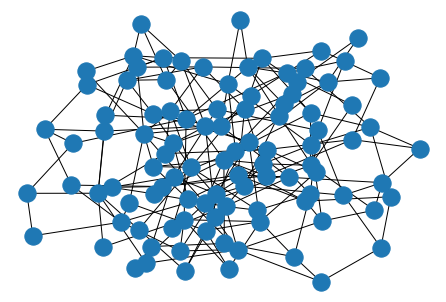

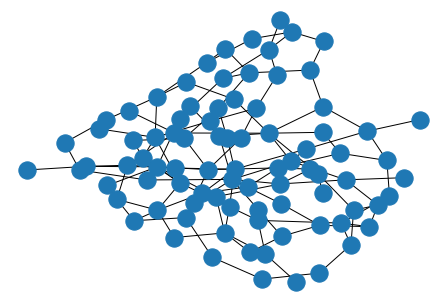

In [271]:
def generate_synthetic_graphs(n_graphs=2,
                              n_nodes=100,
                              main_graph="ER",
                              edge_removal_prob=0.1,
                              node_removal_prob=0.1):
    graphs = []

    if main_graph == "WS":
        g0 = nx.watts_strogatz_graph(n=n_nodes, k=5, p=0.85)
    elif main_graph == "ER":
        g0 = nx.erdos_renyi_graph(n=n_nodes, p=0.15)
    elif main_graph == "PA":
        g0 = nx.barabasi_albert_graph(n=n_nodes, m=n_nodes // 20)
    else:
        raise NotImplementedError

    # Complete graph (in case of isolates or disconnected components):
    complete_disconnected_graph(g0)

    graphs.append(g0)

    for i in range(n_graphs - 1):
        edge_prob = np.random.binomial(1, edge_removal_prob, size=g0.number_of_edges()).astype(bool)
        sampled_edges = np.array(list(g0.edges()))[~edge_prob]

        ng = nx.Graph()
        ng.add_edges_from(sampled_edges)

        node_prob = np.random.binomial(1, node_removal_prob, size=ng.number_of_nodes()).astype(bool)
        sampled_nodes = np.array(list(ng.nodes()))[node_prob]

        ng.remove_nodes_from(sampled_nodes)

        # Complete graph (in case of isolates or disconnected components):
        complete_disconnected_graph(ng)

        graphs.append(ng)

    return graphs

graphs = generate_synthetic_graphs(main_graph='WS')

nx.draw(graphs[0])
plt.show()
nx.draw(graphs[1])

In [276]:
'Cosine' in str(torch.nn.CosineEmbeddingLoss())

True

In [277]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
input1 = torch.abs(torch.randn(10, 5))
input2 = torch.abs(torch.randn(10, 5))
cos(input1, input2)

tensor([0.7619, 0.8915, 0.5060, 0.7231, 0.7091, 0.4365, 0.7023, 0.7562, 0.8312,
        0.7898])

In [283]:
from itertools import product
random.sample(range(int(1e15)), 5)

[665561753744250,
 271810438751116,
 574708974622176,
 938691397862694,
 953866777325184]

In [279]:
range(100)

range(0, 100)

In [287]:
row = torch.Tensor(list(random.sample(range(15000), 100))).to(torch.long)
col = torch.Tensor(list(random.sample(range(10000), 100))).to(torch.long)

neg_adj_mask = torch.ones(15000, 10000, dtype=torch.uint8)
neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
neg_adj_mask[row, col] = 0

neg_adj_mask.nonzero().t().size()

torch.Size([2, 49994965])

In [291]:
import glob, os
graph_data = []

for gf in glob.glob("./data/arXiv/edgelist_data/*.edgelist"):
    g = nx.read_edgelist(gf)
    g.graph['name'] = os.path.basename(gf).replace('.edgelist', '')
    graph_data.append(g)


pair_data = []

for i in range(len(graph_data)):
    for j in range(i + 1, len(graph_data)):
        pair_data.append({
            'g1': graph_data[i].graph['name'],
            'g2': graph_data[j].graph['name'],
            'g1_n': graph_data[i].number_of_nodes(),
            'g2_n': graph_data[j].number_of_nodes(),
            'n_anchors': len(list(set(graph_data[i].nodes()).intersection(set(graph_data[j].nodes()))))
        })

df = pd.DataFrame(pair_data)
df

g1                  g2  g1_n  g2_n  n_anchors
0   cond-mat.dis-nn               cs.SI  3506  4946        933
1   cond-mat.dis-nn     physics.data-an  3506  5465       1400
2   cond-mat.dis-nn               q-bio  3506   660        221
3   cond-mat.dis-nn             math-ph  3506   361         82
4   cond-mat.dis-nn  cond-mat.stat-mech  3506  1451        499
..              ...                 ...   ...   ...        ...
73         q-bio.BM            q-bio.MN   700  1905         30
74         q-bio.BM               cs.CV   700   377          4
75          math.OC            q-bio.MN  1605  1905        190
76          math.OC               cs.CV  1605   377         48
77         q-bio.MN               cs.CV  1905   377         70

[78 rows x 5 columns]

In [296]:
df[df['g1_n'] < 1000]

g1                  g2  g1_n  g2_n  n_anchors
33     q-bio             math-ph   660   361          8
34     q-bio  cond-mat.stat-mech   660  1451        110
35     q-bio      physics.bio-ph   660  2956        160
36     q-bio      physics.soc-ph   660  1594         81
37     q-bio             nlin.AO   660  1270         30
38     q-bio            q-bio.BM   660   700         12
39     q-bio             math.OC   660  1605        103
40     q-bio            q-bio.MN   660  1905         55
41     q-bio               cs.CV   660   377         21
42   math-ph  cond-mat.stat-mech   361  1451         26
43   math-ph      physics.bio-ph   361  2956         60
44   math-ph      physics.soc-ph   361  1594        160
45   math-ph             nlin.AO   361  1270          5
46   math-ph            q-bio.BM   361   700          1
47   math-ph             math.OC   361  1605         24
48   math-ph            q-bio.MN   361  1905        114
49   math-ph               cs.CV   361   377         15
72  q-bio.BM             math.OC   700  1605         37
73  q-bio.BM            q-bio.MN   700  1905         30
74  q-bio.BM               cs.CV   700   377          4

In [300]:
pd.read_csv("metrics/data/synthetic/WS/n_1000/erp_0.2/nrp_0.2/SiameseGNN_cosine_tr_0.8_kn_3/paired_metrics.csv",
            index_col=0).describe()

accuracy       MAP  precision@1  precision@3  precision@5  \
count  2.000000  2.000000     2.000000     2.000000     2.000000   
mean   0.753391  0.865323     0.814427     0.914303     0.926634   
std    0.022669  0.032480     0.047954     0.016566     0.006103   
min    0.737361  0.842356     0.780518     0.902589     0.922318   
25%    0.745376  0.853840     0.797472     0.908446     0.924476   
50%    0.753391  0.865323     0.814427     0.914303     0.926634   
75%    0.761406  0.876806     0.831381     0.920160     0.928792   
max    0.769420  0.888290     0.848335     0.926017     0.930949   

       precision@10  precision@20  precision@30  
count      2.000000      2.000000      2.000000  
mean       0.930333      0.932799      0.932799  
std        0.009591      0.011335      0.011335  
min        0.923551      0.924784      0.924784  
25%        0.926942      0.928792      0.928792  
50%        0.930333      0.932799      0.932799  
75%        0.933724      0.936806      0.936806  
max        0.937115      0.940814      0.940814

In [302]:
graph_data = [1, 2, 3]
[(g1, g2) for i, g1 in enumerate(graph_data) for j, g2 in enumerate(graph_data) if i != j]

[(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]

In [11]:
ei = np.random.choice(int(1e7), size=(2, int(1e7)))
scores = np.random.uniform(size=10000000)

def greedy_matching(total_edge_index, sim_scores):

    pred_pairs = []

    while total_edge_index.shape[1] > 0:
        pair_idx = np.argmax(sim_scores)

        a, b = total_edge_index[:, pair_idx].flatten()
        pred_pairs.append((a, b))
        print('bef')
        step_filt = (total_edge_index[0, :] != a) & (total_edge_index[1, :] != b)
        print('aft')
        total_edge_index = total_edge_index[:, step_filt]
        sim_scores = sim_scores[step_filt]
        print('filt')
    return pred_pairs


In [28]:
%timeit ei[:,np.nonzero((ei[0, :] != 5) & (ei[1, :] != 100))]

314 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit np.argmax(scores)

6.23 ms ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
import dask.array as da
x = da.from_array(scores, chunks=(100000,))

%timeit da.argmax(x)

1.51 ms ± 4.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%timeit da.argmax(x)

38.1 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
daei = da.from_array(ei, chunks=(10000, 2))
%timeit (daei[0, :] != 5) & (daei[1, :] != 100)

KeyboardInterrupt: 

In [23]:
tei = torch.Tensor(ei)

In [26]:
%timeit tei[:, torch.nonzero((tei[0, :] != 5) & (tei[1, :] != 100))]

156 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
tscores = torch.Tensor(scores[:100000])

In [41]:
%timeit np.argmax(tscores)

98.2 µs ± 945 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [42]:
%timeit torch.argmax(tscores)

212 µs ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [47]:
mapping = pd.read_csv("data/flickr_vs_lastfm/flickr-lastfm.map.raw", sep="\s+", names=['flickr', 'lastfm'])
flickr_nodes = pd.read_csv("data/flickr_vs_lastfm/flickr/flickr.nodes", sep='\t', names=['id', 'username'])
lastfm_nodes = pd.read_csv("data/flickr_vs_lastfm/lastfm/lastfm.nodes", sep='\t', names=['id', 'username'])

flickr_nodes

id      username
0            0   rosie_hardy
1            1       ndybisz
2            2         chiie
3            3  brookeshaden
4            4    lorenzodom
...        ...           ...
215490  215490     AbbyCheng
215491  215491         ATIAC
215492  215492          A7eh
215493  215493         63395
215494  215494          -jO-

[215495 rows x 2 columns]

In [62]:
fg = nx.read_edgelist("data/flickr_vs_lastfm/flickr/flickr.edges", nodetype=int)

NodeView((0, 32769, 2, 3, 7, 9, 10, 12, 65551, 32785, 18, 20, 21, 131095, 25, 26, 33, 34, 71003, 1, 37, 38, 39, 40, 41, 32811, 44, 45, 47, 131120, 32817, 50, 52, 54, 55, 56, 32825, 58, 60, 147466, 32831, 66, 32838, 71, 73, 65616, 32849, 83, 85, 32854, 87, 89, 90, 65629, 95, 96, 32865, 32866, 99, 102, 17, 131179, 108, 32786, 110, 114, 115, 117, 118, 98423, 122, 126, 129, 65666, 131, 132, 133, 65672, 144, 145, 65683, 149, 152, 153, 155, 65692, 98463, 65696, 161, 162, 65699, 164, 166, 98472, 32938, 32939, 172, 98485, 182, 67656, 189, 32961, 65733, 32801, 32968, 43724, 32970, 16418, 65742, 209, 210, 98515, 212, 214, 217, 32988, 222, 65760, 231, 232, 238, 33010, 243, 33013, 65782, 33016, 253, 258, 261, 268, 269, 131342, 271, 272, 276, 33046, 280, 283, 33052, 76506, 33054, 290, 27355, 294, 33073, 98610, 98613, 313, 316, 317, 318, 319, 33090, 33092, 325, 327, 329, 332, 333, 335, 33105, 33106, 342, 348, 131424, 356, 33125, 360, 361, 364, 365, 98670, 367, 33136, 65905, 375, 33148, 33149, 383, 3

In [74]:
anchor_nodes = list(flickr_nodes.loc[flickr_nodes['username'].isin(mapping['flickr']), 'id'].values)
final_nodes = []
prob_anchors = []
for an in anchor_nodes:
    try:
        final_nodes += [n for n in fg.neighbors(an)] + [an]
    except Exception:
        prob_anchors.append(an)
        continue

sfg = fg.subgraph(final_nodes)
print(sfg.number_of_nodes())

12974


In [72]:
list(fg.neighbors(5000)).index(5000)

ValueError: 5000 is not in list

In [60]:
fg.nodes()

NodeView(('0', '32769', '2', '3', '7', '9', '10', '12', '65551', '32785', '18', '20', '21', '131095', '25', '26', '33', '34', '71003', '1', '37', '38', '39', '40', '41', '32811', '44', '45', '47', '131120', '32817', '50', '52', '54', '55', '56', '32825', '58', '60', '147466', '32831', '66', '32838', '71', '73', '65616', '32849', '83', '85', '32854', '87', '89', '90', '65629', '95', '96', '32865', '32866', '99', '102', '17', '131179', '108', '32786', '110', '114', '115', '117', '118', '98423', '122', '126', '129', '65666', '131', '132', '133', '65672', '144', '145', '65683', '149', '152', '153', '155', '65692', '98463', '65696', '161', '162', '65699', '164', '166', '98472', '32938', '32939', '172', '98485', '182', '67656', '189', '32961', '65733', '32801', '32968', '43724', '32970', '16418', '65742', '209', '210', '98515', '212', '214', '217', '32988', '222', '65760', '231', '232', '238', '33010', '243', '33013', '65782', '33016', '253', '258', '261', '268', '269', '131342', '271', '272

In [76]:
lg = nx.read_edgelist("data/flickr_vs_lastfm/lastfm/lastfm.edges", nodetype=int)

anchor_nodes = list(lastfm_nodes.loc[lastfm_nodes['username'].isin(mapping['lastfm']), 'id'].values)
final_nodes = []
prob_anchors = []
for an in anchor_nodes:
    try:
        final_nodes += [n for n in lg.neighbors(an)] + [an]
    except Exception:
        prob_anchors.append(an)
        continue

slg = lg.subgraph(final_nodes)
print(slg.number_of_nodes())
#print(flickr_nodes.loc[flickr_nodes['id'].isin(prob_anchors)])
print(prob_anchors)

15436
[136410]


In [83]:
pd.read_csv("data/graph_attributes/multiple_flickr.csv", index_col=0)

gid             id              name  \
0     pooria.hossaini      yekpooria   Pooria Hosseini   
1          jillpropst     propstreet       Jill Propst   
2          vitplister     vitplister  Mattias Mattsson   
3         mbattal1990  mustafabattal    mustafa battal   
4            mvtgomes     marcogomes       Marco Gomes   
...               ...            ...               ...   
2000    henning.brune        ihbrune               NaN   
2001    renancferrari          re844               NaN   
2002     katkovayulia   yuliakatkova     Yulia Katkova   
2003   alex.gomes2192    alexgomesbr               NaN   
2004       randomguru     randomguru       Carlos Rull   

                                 location           hometown  gender  \
0                                  Tehran       Sa\adat abad    male   
1                                     NaN                NaN  female   
2                                     NaN                NaN     NaN   
3                                     NaN                NaN    male   
4                        São Paulo,Brasil           Brasília    male   
...                                   ...                ...     ...   
2000                                  NaN                NaN     NaN   
2001                                  NaN  Rio Grande do Sul    male   
2002                            Lima,Peru           Tashkent  female   
2003                                  NaN              Garça    male   
2004  San Diego, California,United States          San Diego    male   

               status                            occupation  \
0              single                              Team gym   
1              single                                   NaN   
2                 NaN                                   NaN   
3              single                                   NaN   
4              single                          Empreendedor   
...               ...                                   ...   
2000              NaN                                   NaN   
2001           single                                   NaN   
2002  in relationship    Painting, art, photography, design   
2003           single                             Estudante   
2004  in relationship  Musician and Web Developer/Publisher   

                                links  last_active connections aboutme  
0            http://www.yekpooria.com          NaN           8  flickr  
1                                 NaN          NaN           6     NaN  
2     http://vitplister.blogspot.com/          NaN          44     NaN  
3                                 NaN          NaN           7  flickr  
4               http://marcogomes.com          NaN         436  flickr  
...                               ...          ...         ...     ...  
2000        http://flavors.me/ihbrune          NaN          10  flickr  
2001            http://about.me/re844          NaN           2     NaN  
2002     http://blog.yuliakatkova.com          NaN         205  flickr  
2003      http://flavors.me/alexgomes          NaN           0  flickr  
2004            http://carlosrull.com          NaN         218  flickr  

[2005 rows x 12 columns]

In [80]:
final_nodes

[3,
 11,
 35,
 41,
 72,
 77826,
 6148,
 51206,
 12299,
 100365,
 61454,
 12303,
 22544,
 88086,
 82265,
 39940,
 61468,
 14370,
 18468,
 42673,
 16425,
 22570,
 90155,
 90158,
 25949,
 30775,
 34877,
 30784,
 30048,
 79941,
 67654,
 21552,
 102473,
 110666,
 12363,
 37218,
 20559,
 2744,
 69714,
 57427,
 111780,
 34489,
 112730,
 21519,
 49244,
 71774,
 20580,
 4197,
 12391,
 51305,
 56679,
 102509,
 82621,
 129138,
 54291,
 106612,
 33215,
 45174,
 6005,
 12420,
 58391,
 8334,
 27688,
 68291,
 67723,
 20631,
 104601,
 69787,
 96414,
 95479,
 103799,
 30406,
 86341,
 51367,
 37513,
 35527,
 22700,
 88237,
 67759,
 135346,
 90291,
 100532,
 127160,
 100724,
 23583,
 84156,
 133310,
 8383,
 16576,
 65731,
 60790,
 47302,
 6343,
 94409,
 88267,
 80076,
 69838,
 65745,
 26834,
 15054,
 65751,
 30936,
 20697,
 36559,
 2268,
 61662,
 30943,
 55521,
 73954,
 35043,
 63718,
 92391,
 39144,
 10474,
 113703,
 30956,
 53485,
 10480,
 107560,
 98552,
 33015,
 35072,
 63745,
 63747,
 79320,
 39174,

In [85]:
pd.DataFrame({'nodes':list(slg.nodes())})

nodes
0          1
1          2
2          3
3      32771
4          5
...      ...
15431  65524
15432  65525
15433  32761
15434  65530
15435  98303

[15436 rows x 1 columns]

In [86]:
mapping

flickr          lastfm
0        vitplister      vitplister
1        marcogomes  MarcoGomes.com
2      daemonfreaks           jun-g
3    atanastsvetkov  atanastsvetkov
4    ian-betteridge   ianbetteridge
..              ...             ...
636      dirtygreek      dirtygreek
637     allwebdeals     allwebdeals
638   theblakeayers        blakis03
639     danikardone     danikardone
640        missgosh        MissGosh

[641 rows x 2 columns]

In [87]:
np.load("data/flickr_vs_lastfm/edgelist_data/lastfm.attr.npy")

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [93]:
from multiprocessing import Pool
import time
import itertools

import matplotlib.pyplot as plt
import networkx as nx


def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def _betmap(G_normalized_weight_sources_tuple):
    """Pool for multiprocess only accepts functions with one argument.
    This function uses a tuple as its only argument. We use a named tuple for
    python 3 compatibility, and then unpack it when we send it to
    `betweenness_centrality_source`
    """
    return nx.betweenness_centrality_source(*G_normalized_weight_sources_tuple)


def betweenness_centrality_parallel(G, processes=None):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      [True] * num_chunks,
                      [None] * num_chunks,
                      node_chunks))
    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [ ]:
if __name__ == '__main__':
    print(betweenness_centrality_parallel(nx.erdos_renyi_graph(10000, 0.15), 5))


KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):


  File "/Users/szabad/opt/miniconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()



KeyboardInterrupt
Process ForkPoolWorker-32:
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0xa2c45ce60> (for post_execute):


Exception ignored in: <function Context.__del__ at 0x110b8b680>
Traceback (most recent call last):
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/zmq/sugar/context.py", line 50, in __del__
    self.term()


KeyboardInterrupt: 

  File "zmq/backend/cython/context.pyx", line 91, in zmq.backend.cython.context.Context.term
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [2]:
nx.closeness_centrality(nx.erdos_renyi_graph(10000, 0.15))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-9daaa0f434df>", line 1, in <module>
    nx.closeness_centrality(nx.erdos_renyi_graph(10000, 0.15))
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/networkx/algorithms/centrality/closeness.py", line 124, in closeness_centrality
    sp = path_length(G, n)
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/networkx/algorithms/shortest_paths/unweighted.py", line 66, in single_source_shortest_path_length
    return dict(_single_shortest_path_length(G.adj, nextlevel, cutoff))
  File "/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/networkx/algorithms/shortest_paths/unweighted.py", line 92, in _single_shortest_path_length
    nextlevel.update(adj[v])  # add neighbors of v
  File "/Users/szabad/opt/miniconda3/lib/python3.

KeyboardInterrupt: 

In [ ]:
import scipy

def fast_closeness_centrality(G):
    A = nx.adjacency_matrix(G).tolil()
    D = scipy.sparse.csgraph.floyd_warshall( \
                 A, directed=False, unweighted=False)

    n = D.shape[0]
    closeness_centrality = {}
    for r in range(0, n):

        cc = 0.0

        possible_paths = list(enumerate(D[r, :]))
        shortest_paths = dict(filter( \
            lambda x: not x[1] == np.inf, possible_paths))

        total = sum(shortest_paths.values())
        n_shortest_paths = len(shortest_paths) - 1.0
        if total > 0.0 and n > 1:
            s = n_shortest_paths / (n - 1)
            cc = (n_shortest_paths / total) * s
        closeness_centrality[r] = cc
    return closeness_centrality

fast_closeness_centrality(nx.erdos_renyi_graph(10000, 0.15))

In [68]:
import bz2
import glob
import os
import _pickle as cPickle

def unpickle_data(input_file):
    with bz2.BZ2File(input_file, 'rb') as inpf:
        return cPickle.load(inpf)

g0 = unpickle_data("data/synthetic/WS/n_100/erp_0.2/nrp_0.2/tg_datasets/tr_0.7/g0.pbz2")

g0.gidx, g0.graph_name, g0.anchor_data.keys()

('g0', 'g0', dict_keys(['g1']))

In [69]:
g0.anchor_data

{'g1': {'positive_anchors': ['28',
   '0',
   '40',
   '21',
   '29',
   '3',
   '47',
   '88',
   '86',
   '97',
   '64',
   '14',
   '52',
   '96',
   '56',
   '94',
   '57',
   '41',
   '11',
   '54',
   '62',
   '59',
   '65',
   '84',
   '58',
   '80',
   '42',
   '60',
   '7',
   '23',
   '39',
   '18',
   '34',
   '79',
   '69',
   '6',
   '99',
   '22',
   '76',
   '31',
   '15',
   '61',
   '33',
   '24',
   '77',
   '43',
   '49',
   '53',
   '98',
   '26',
   '63',
   '82',
   '78',
   '9',
   '17',
   '74',
   '67',
   '48',
   '13',
   '16',
   '25',
   '85',
   '1',
   '2',
   '89',
   '75',
   '92',
   '87',
   '55',
   '90',
   '71',
   '91',
   '20',
   '35',
   '51'],
  'train_positive_anchors': ['78',
   '9',
   '17',
   '74',
   '67',
   '48',
   '13',
   '16',
   '25',
   '85',
   '1',
   '2',
   '89',
   '75',
   '92',
   '87',
   '55',
   '90',
   '71',
   '91',
   '20',
   '35',
   '51'],
  'test_positive_anchors': ['28',
   '0',
   '40',
   '21',
   '29',
   '3

In [70]:
g0.anchor_data['g1']['closest_anchor_data']

{0: ([52,
   51,
   55,
   85,
   16,
   83,
   13,
   50,
   56,
   78,
   27,
   88,
   47,
   6,
   3,
   65,
   33,
   92,
   95,
   45,
   30,
   90,
   70],
  [0.3333333333333333,
   0.25,
   0.25,
   0.25,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.14285714285714285]),
 1: ([52,
   55,
   51,
   13,
   50,
   56,
   27,
   78,
   88,
   85,
   6,
   92,
   3,
   45,
   33,
   30,
   47,
   90,
   95,
   16,
   83,
   65,
   70],
  [0.5,
   0.3333333333333333,
   0.3333333333333333,
   0.25,
   0.25,
   0.25,
   0.25,
   0.25,
   0.25,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.2,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666,
   0.16666666666666666]),
 2: ([85

In [27]:
g0.anchor_data['g0']['train_anchor_edge_index']

tensor([[70, 71, 72, 73, 75, 76, 78, 81, 82, 83, 84, 85, 87, 88, 90, 91, 92, 94,
         95, 96, 97, 98, 99],
        [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
         70, 71, 72, 73, 74]])

In [28]:
g0.anchor_data['g0']['anchor_edge_index']

tensor([[ 0,  2,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 19, 20, 21, 22, 23, 25,
         26, 27, 28, 30, 32, 33, 34, 35, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48,
         49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 65, 66, 68, 70, 71,
         72, 73, 75, 76, 78, 81, 82, 83, 84, 85, 87, 88, 90, 91, 92, 94, 95, 96,
         97, 98, 99],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74]])

In [32]:
anchor_ei = torch.Tensor([[1., 2.], [3., 4.]])

In [30]:
np.random.shuffle(tt)

In [31]:
tt

tensor([[1., 2.],
        [1., 2.]])

In [55]:
li = [1, 2]
anchor_ei = torch.Tensor([[1., 2.], [3., 4.]])

perm = torch.tensor(random.sample(range(anchor_ei.size(1)), anchor_ei.size(1))).to(torch.long)
anchor_ei = anchor_ei[:, perm]
anchor_ei, list(np.array(li)[perm.numpy()])

(tensor([[2., 1.],
         [4., 3.]]),
 [2, 1])

In [51]:
li = [1, 2]
np.array(li)[perm.numpy()]

array([2, 1])

In [72]:
import seaborn as sns

In [73]:
sns.load_dataset("exercise")

Unnamed: 0  id     diet  pulse    time     kind
0            0   1  low fat     85   1 min     rest
1            1   1  low fat     85  15 min     rest
2            2   1  low fat     88  30 min     rest
3            3   2  low fat     90   1 min     rest
4            4   2  low fat     92  15 min     rest
..         ...  ..      ...    ...     ...      ...
85          85  29   no fat    135  15 min  running
86          86  29   no fat    130  30 min  running
87          87  30   no fat     99   1 min  running
88          88  30   no fat    111  15 min  running
89          89  30   no fat    150  30 min  running

[90 rows x 6 columns]

In [82]:
def transform_paired_metrics_df(met_fname):
    met_df = pd.read_csv(
        met_fname,
        index_col=0)

    met_df = met_df[["pair", "precision@1", "precision@3", "precision@5", "precision@10", "precision@30"]]

    ndf = pd.melt(met_df, id_vars="pair",
                  value_vars=["precision@1", "precision@3", "precision@5", "precision@10", "precision@30"],
                  var_name='k', value_name='Precision@k')

    ndf['k'] = ndf['k'].map({
        "precision@1": 1,
        "precision@3": 3,
        "precision@5": 5,
        "precision@10": 10,
        "precision@30": 30
    })

    ndf['model'] = os.path.basename(os.path.dirname(met_fname)).split("_")[0]

    return ndf

df1 = transform_paired_metrics_df("metrics/data/synthetic/WS/n_100/erp_0.2/nrp_0.1/SiameseGNN_cosine_tr_0.8_kn_3/paired_metrics.csv")
df2 = transform_paired_metrics_df("metrics/data/synthetic/WS/n_100/erp_0.2/nrp_0.1/AnchoredSiameseGNN_cosine_tr_0.8_kn_3/paired_metrics.csv")

pd.concat([df1, df2])


pair   k  Precision@k               model
0  g1-->g0   1     1.000000          SiameseGNN
1  g0-->g1   1     1.000000          SiameseGNN
2  g1-->g0   3     1.000000          SiameseGNN
3  g0-->g1   3     1.000000          SiameseGNN
4  g1-->g0   5     1.000000          SiameseGNN
5  g0-->g1   5     1.000000          SiameseGNN
6  g1-->g0  10     1.000000          SiameseGNN
7  g0-->g1  10     1.000000          SiameseGNN
8  g1-->g0  30     1.000000          SiameseGNN
9  g0-->g1  30     1.000000          SiameseGNN
0  g1-->g0   1     0.797753  AnchoredSiameseGNN
1  g0-->g1   1     0.808989  AnchoredSiameseGNN
2  g1-->g0   3     0.853933  AnchoredSiameseGNN
3  g0-->g1   3     0.876404  AnchoredSiameseGNN
4  g1-->g0   5     0.853933  AnchoredSiameseGNN
5  g0-->g1   5     0.876404  AnchoredSiameseGNN
6  g1-->g0  10     0.853933  AnchoredSiameseGNN
7  g0-->g1  10     0.898876  AnchoredSiameseGNN
8  g1-->g0  30     0.898876  AnchoredSiameseGNN
9  g0-->g1  30     0.932584  AnchoredSiameseGNN

In [84]:
met_dir = "metrics/arXiv"
os.path.join(met_dir, "*/paired_metrics.csv")

'metrics/arXiv/*/paired_metrics.csv'